## Customer Churn Analytics

<ul>
    <li>What is Survival Analysis</li>
    <li>Import Dataset</li>
    <li>What is Censoring</li>
    <li>Survival Function</li>
    <li>Unevariate analysis using Kaplan-Meier</li>
    <li>Hazard Function </li>
    <li>Nelson-Aalen model</li>
    <li>Survival Regression </li>
    <li>Cox regression </li>
</ul>

### What is Survival Analysis
survival analysis was developed to measure lifespans of individual

survival analysis can be applied to not only births and deaths, but any duration. Medical professionals might be interested in the time between childbirths, where a birth in this case is the event of having a child, and a death is becoming pregnant again! (obviously, we are loose with our definitions of birth and death) Another example is users subscribing to a service: a birth is a user who joins the service, and a death is when the user leaves the service.

One of SA Applications is Customer Churn:

In this Notebook we will try to develope the relationship between churn and other factors, also we will make prediction using Cox regression

Our main factors is Tenure as time, Customer status as Event and other factors(AKA Featuers)

### import Dataset and Quick Exploration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
df = pd.read_csv('telecom_customer_churn.csv')
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [3]:
df.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

### Extract main features for simpelecity 

In [4]:
ch_data = df[['Tenure in Months','Contract','Customer Status', 'Churn Category', 'Churn Reason']]
ch_data.head()

,Tenure in Months,Contract,Customer Status,Churn Category,Churn Reason
0,9,One Year,Stayed,NaN,NaN
1,9,Month-to-Month,Stayed,NaN,NaN
2,4,Month-to-Month,Churned,Competitor,Competitor had better devices
3,13,Month-to-Month,Churned,Dissatisfaction,Product dissatisfaction
4,3,Month-to-Month,Churned,Dissatisfaction,Network reliability


In [5]:
ch_data['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

### Censoring

At the time you want to make inferences about durations, it is possible that not all the death events(Churned) have occurred yet. For example, a medical professional will not wait 50 years for each individual in the study to pass away before investigating – he or she is interested in making decisions after only a few years, or months possibly.

In our example during the study there are customers not churned yet, the called Non-Censored data.

The individuals in a population who have not been subject to the death event are labeled as right-censored, i.e., we did not (or can not) view the rest of their life history due to some external circumstances. All the information we have on these individuals are their current lifetime durations (which is naturally less than their actual lifetimes).

<img src='survival_analysis_intro_censoring.png' />



Example lifetimes of individuals. We only observe up to time 10, but the blue individuals have not died yet (i.e. they are censored).



### Flag censored and non-censored data
censored data (AKA Not Churned) = 0


non-Censored data (AKA Churned) = 1

In [6]:
def check_observed(ch_data):
    if ch_data['Customer Status'] == 'Joined':
        flag = 0
    elif ch_data['Customer Status'] == 'Stayed':
        flag = 0
    else:
        flag = 1
    return flag

In [7]:
ch_data['observed'] = ch_data.apply(check_observed, axis=1)
ch_data.head()

<ipython-input-7-bbe56ea4cff6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch_data['observed'] = ch_data.apply(check_observed, axis=1)


,Tenure in Months,Contract,Customer Status,Churn Category,Churn Reason,observed
0,9,One Year,Stayed,NaN,NaN,0
1,9,Month-to-Month,Stayed,NaN,NaN,0
2,4,Month-to-Month,Churned,Competitor,Competitor had better devices,1
3,13,Month-to-Month,Churned,Dissatisfaction,Product dissatisfaction,1
4,3,Month-to-Month,Churned,Dissatisfaction,Network reliability,1


### Porportion of censored data

In [8]:
ch_data.observed.mean()

0.2653698707936959

### Survival Function
the survival function defines the probability the death event has not occurred yet at time t, or equivalently, the probability of surviving past time t

<img src='intro_survival_function.png' />

### Survival Curve
#### Estimating the survival function using Kaplan-Meier


In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [10]:
T = ch_data["Tenure in Months"]
E = ch_data["observed"]
labels = ch_data['Contract']

kmf.fit(T, event_observed=E)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

<AxesSubplot:xlabel='timeline'>

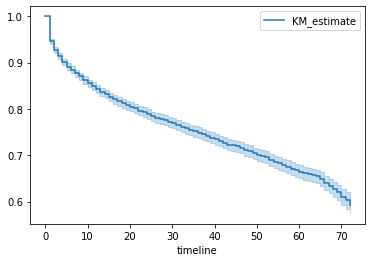

In [11]:
kmf.plot_survival_function()

### The Infleuence of Contract Type 

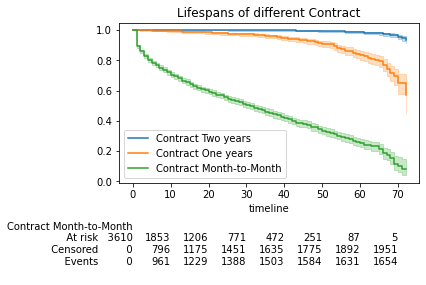

In [12]:
ax = plt.subplot(111)


kmf.fit(ch_data[ch_data["Contract"] == "Two Year"]['Tenure in Months'], event_observed=ch_data[ch_data["Contract"] == "Two Year"]['observed'], label="Contract Two years")
kmf.plot_survival_function(ax=ax)

kmf.fit(ch_data[ch_data["Contract"] == "One Year"]['Tenure in Months'], event_observed=ch_data[ch_data["Contract"] == "One Year"]['observed'], label="Contract One years")
kmf.plot_survival_function(ax=ax)

kmf.fit(ch_data[ch_data["Contract"] == "Month-to-Month"]['Tenure in Months'], event_observed=ch_data[ch_data["Contract"] == "Month-to-Month"]['observed'], label="Contract Month-to-Month")
kmf.plot_survival_function(ax=ax,at_risk_counts=True)


plt.title("Lifespans of different Contract");


### Hazard function
We are also interested in the probability of the death event occurring at time t, given that the death event has not occurred yet

#### Estimating hazard rates using Nelson-Aalen


In [13]:
T = ch_data["Tenure in Months"]
E = ch_data["observed"]

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)


<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 7043 total observations, 5174 right-censored observations>

          NA_estimate
timeline             
0.0          0.000000
1.0          0.055460
2.0          0.074773
3.0          0.090069
4.0          0.104017


<AxesSubplot:xlabel='timeline'>

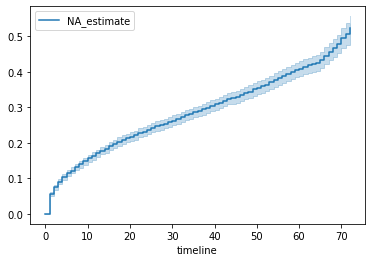

In [14]:
print(naf.cumulative_hazard_.head())
naf.plot_cumulative_hazard()


## Data Preparing and Pre-processing

In [15]:
df.head(1)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.3,0.0,0,381.51,974.81,Stayed,NaN,NaN


In [16]:
df.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

#### Drop unwanted columns

In [17]:
df = df.drop(['Customer ID', 'Zip Code', 'Latitude', 'Longitude'], axis=1)

#### Handle Missing Values

In [18]:
df.isna().sum()

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                     1526
Streaming Music                      1526
Unlimited Data                       1526
Contract                                0
Paperless Billing                 

In [19]:
df['Internet Service'].value_counts()

Yes    5517
No     1526
Name: Internet Service, dtype: int64

In [20]:
df['Phone Service'].value_counts()

Yes    6361
No      682
Name: Phone Service, dtype: int64

In [21]:
import missingno as msno

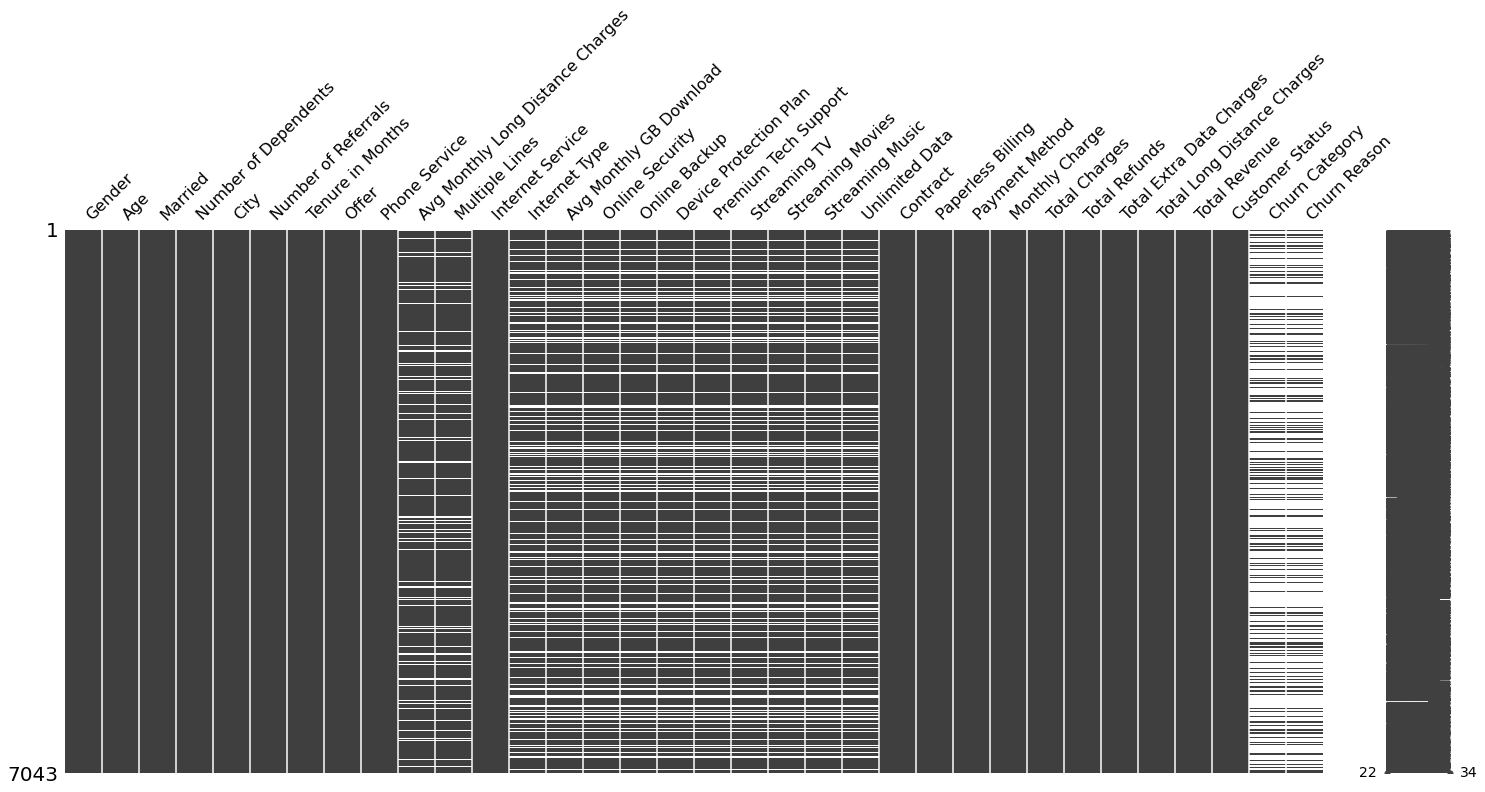

In [22]:
msno.matrix(df)
plt.show()

<AxesSubplot:>

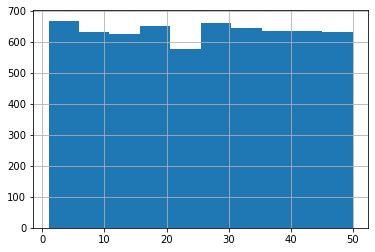

In [23]:
df['Avg Monthly Long Distance Charges'].hist()

In [24]:
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(df['Avg Monthly Long Distance Charges'].mean())

In [25]:
df['Multiple Lines'].value_counts()

No     3390
Yes    2971
Name: Multiple Lines, dtype: int64

In [26]:
df['Multiple Lines'].fillna('No Phone Services', inplace = True)

In [27]:
df.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

In [28]:
## No internet services related columns
cols = ['Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data']

In [29]:
for col in cols:
    df[col].fillna('No Internet Service', inplace = True)

In [30]:
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].replace('No Internet Service',0)

In [31]:
for col in ['Churn Category', 'Churn Reason']:
    df[col].fillna('Not Churned', inplace=True)

In [32]:
df.isna().sum().sum()

0

#### Check Numerical Features

In [33]:
df.describe()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,32.386767,25.420517,20.515405,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,3.001199,24.542061,13.495231,20.418940,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,0.000000,1.000000,1.010000,0.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,0.000000,9.000000,14.455000,3.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,0.000000,29.000000,25.420517,17.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,3.000000,55.000000,36.395000,27.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


#### Data Preprcessing

In [34]:
df['Customer Status'] = df['Customer Status'].replace('Joined','Stayed')
df['Customer Status'].unique()

array(['Stayed', 'Churned'], dtype=object)

In [35]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['Customer Status'] = enc.fit_transform(df['Customer Status'])

#### Encoding

In [36]:
### Extract Categorical columns
cat_columns = []
num_columns = []
one_hot = []
label_encod = []
for col in df.columns:
    if df[col].dtype == 'object':
        cat_columns.append(col)
        if df[col].nunique() < 10:
            one_hot.append(col)
        else:
            label_encod.append(col)
    else:
        num_columns.append(col)

In [37]:
#### Look at unique values in columns
for col in df.columns:
    print(col)
    print(f"No of Unique values is: {df[col].nunique()}")
    if df[col].nunique() < 10:
        print('One Hot Encoding')
    else:
        print('Label Encoding')
    print("===============================")

Gender
No of Unique values is: 2
One Hot Encoding
Age
No of Unique values is: 62
Label Encoding
Married
No of Unique values is: 2
One Hot Encoding
Number of Dependents
No of Unique values is: 10
Label Encoding
City
No of Unique values is: 1106
Label Encoding
Number of Referrals
No of Unique values is: 12
Label Encoding
Tenure in Months
No of Unique values is: 72
Label Encoding
Offer
No of Unique values is: 6
One Hot Encoding
Phone Service
No of Unique values is: 2
One Hot Encoding
Avg Monthly Long Distance Charges
No of Unique values is: 3584
Label Encoding
Multiple Lines
No of Unique values is: 3
One Hot Encoding
Internet Service
No of Unique values is: 2
One Hot Encoding
Internet Type
No of Unique values is: 4
One Hot Encoding
Avg Monthly GB Download
No of Unique values is: 50
Label Encoding
Online Security
No of Unique values is: 3
One Hot Encoding
Online Backup
No of Unique values is: 3
One Hot Encoding
Device Protection Plan
No of Unique values is: 3
One Hot Encoding
Premium Tech 

In [38]:
one_hot

['Gender',
 'Married',
 'Offer',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Churn Category']

#### One Hot Encoding

In [39]:
df = pd.get_dummies(df, columns = one_hot)

In [40]:
label_encod

['City', 'Churn Reason']

In [41]:
enc = LabelEncoder()
for col in label_encod:
    df[col] = enc.fit_transform(df[col])

## Modeling

### Survival regression
Often we have additional data aside from the duration that we want to use. The technique is called survival regression – the name implies we regress covariates (e.g., age, country, etc.) against another variable – in this case durations. Similar to the logic in the first part of this tutorial, we cannot use traditional methods like linear regression because of censoring.



In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15)

### Cox’s proportional hazard model

In [43]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(train, duration_col='Tenure in Months', event_col='Customer Status')


<lifelines.CoxPHFitter: fitted with 5986 total observations, 1570 right-censored observations>

In [44]:
cph.print_summary()  # access the individual results using cph.summary


<lifelines.CoxPHFitter: fitted with 5986 total observations, 1570 right-censored observations>
             duration col = 'Tenure in Months'
                event col = 'Customer Status'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5986
number of events observed = 4416
   partial log-likelihood = -28528.65
         time fit was run = 2022-08-12 12:12:45 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
Age                                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Number of Dependents                         0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
City                                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Number of Referrals                         -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
Avg Monthly Long Distance Charges            0.05       1.05       0.00             0.05             0.06                 1.05                 1.06
Avg Monthly GB Download                      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Monthly Charge                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Total Charges                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Total Refunds                               -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
Total Extra Data Charges                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Total Long Distance Charges                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Total Revenue                               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Churn Reason                                 0.18       1.20       0.20            -0.22             0.58                 0.81                 1.79
Gender_Female                                0.02       1.02       1.83            -3.56             3.60                 0.03                36.68
Gender_Male                                 -0.02       0.98       1.83            -3.60             3.56                 0.03                35.29
Married_No                                   0.10       1.10       1.83            -3.49             3.68                 0.03                39.68
Married_Yes                                 -0.10       0.91       1.83            -3.68             3.49                 0.03                32.72
Offer_None                                  -0.14       0.87       1.59            -3.27             2.98                 0.04                19.68
Offer_Offer A                               -0.89       0.41       1.59            -4.01             2.24                 0.02                 9.35
Offer_Offer B                               -0.14       0.87       1.59            -3.26             2.99                 0.04                19.86
Offer_Offer C                               -0.10       0.90       1.59            -3.23             3.02                 0.04                20.51
Offer_Offer D                                0.10       1.11       1.59            -3.02             3.23                 0.05                25

In [45]:
cph.baseline_cumulative_hazard_.head(30)

,baseline cumulative hazard
1.0,0.000614
2.0,0.001016
3.0,0.001426
4.0,0.001869
5.0,0.002263
6.0,0.002705
7.0,0.003236
8.0,0.003954
9.0,0.004685
10.0,0.005825


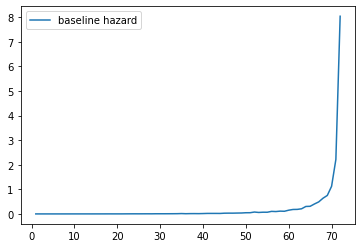

In [48]:
cph.baseline_hazard_.plot()
plt.show()

<AxesSubplot:>

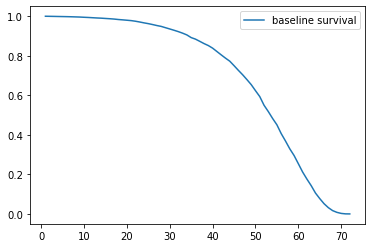

In [50]:
cph.baseline_survival_.plot()

In [52]:
cph.check_assumptions(train, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5986 total observations, 1570 right-censored observations>
         test_name = proportional_hazard_test

---
                                                 test_statistic      p  -log2(p)
Age                                        km              1.32   0.25      2.00
                                           rank            1.04   0.31      1.70
Avg Monthly GB Download                    km              0.06   0.81      0.30
                                           rank            0.01   0.93      0.11
Avg Monthly Long Distance Charges          km             62.95 <0.005     48.75
                                           rank           81.85 <0.005     62.56
Churn Category_Attitude                    km              0.00   0.96      0.06
                                           rank            0.00   0.96      0.06
Churn Category_Competitor                  km              0.00   0.96      0.06
                                           rank            0.00   0.95      0.07
Churn Category_Dissatisfaction             km              0.01   0.92      0.12
                                           rank            0.01   0.92      0.12
Churn Category_Not Churned                 km              0.02   0.90      0.15
                                           rank            0.02   0.90      0.16
Churn Category_Other                       km              0.01   0.94      0.10
                                           rank            0.01   0.93      0.10
Churn Category_Price                       km              0.00   0.95      0.07
                                           rank            0.00   0.95      0.07
Churn Reason                               km              0.00   0.95      0.07
                                           rank            0.00   0.95      0.07
City                                       km              1.21   0.27      1.89
                                           rank            1.47   0.23      2.15
Contract_Month-to-Month                    km              0.01   0.94      0.09
                                           rank            0.01   0.93      0.10
Contract_One Year                          km              0.00   0.97      0.05
                                           rank            0.00   0.96      0.06
Contract_Two Year                          km              0.00   0.96      0.06
                                           rank            0.00   0.95      0.07
Device Protection Plan_No                  km              0.00   1.00      0.01
                                           rank            0.00   1.00      0.01
Device Protection Plan_No Internet Service km              0.00   0.98      0.03
                                           rank            0.00   0.98      0.03
Device Protection Plan_Yes                 km              0.00   0.97      0.04
                                           rank            0.00   0.97      0.05
Gender_Female                              km              0.00   0.99      0.01
                                           rank            0.00   0.99      0.01
Gender_Male                                km              0.00   0.99      0.01
                                           rank            0.00   0.99      0.01
Internet Service_No                        km              0.00   0.98      0.03
                                           rank            0.00   0.98      0.03
Internet Service_Yes                       km              0.00   0.98      0.03
                                           rank            0.00   0.98      0.03
Internet Type_Cable                        km              0.01   0.91      0.13
                                           rank            0.01   0.90      0.15
Internet Type_DSL                          km              0.01   0.93      



1. Variable 'Avg Monthly Long Distance Charges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Avg Monthly Long Distance Charges' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'Avg Monthly Long Distance Charges' using pd.cut, and then
specify it in `strata=['Avg Monthly Long Distance Charges', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Total Refunds' failed the non-proportional test: p-value is 0.0085.

   Advice 1: the functional form of the variable 'Total Refunds' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is ve

[]

In [54]:
cph.score(test)

-3.405269723857324

<AxesSubplot:xlabel='log(HR) (95% CI)'>

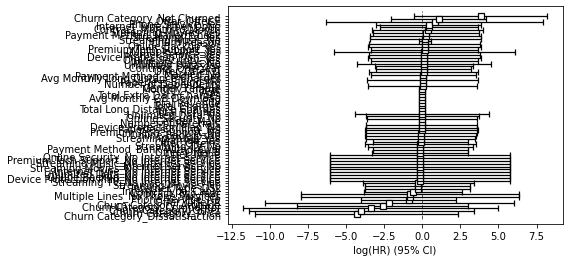

In [56]:
cph.plot()

In [59]:
pred = test.iloc[0:5]
pred = pred.drop(['Tenure in Months', 'Customer Status'], axis=1)

<AxesSubplot:>

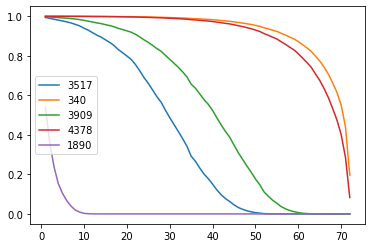

In [60]:
cph.predict_survival_function(pred).plot()

In [67]:
test[['Tenure in Months', 'Customer Status']].head()

,Tenure in Months,Customer Status
3517,17,1
340,5,0
3909,47,1
4378,67,1
1890,1,1


In [73]:
cph.predict_partial_hazard(test)

3517      10.712386
340        0.100349
3909       3.664412
4378       0.153476
1890    1002.952454
           ...     
2508       0.068757
5593       2.175547
3710       0.352182
920       55.719739
56        19.426689
Length: 1057, dtype: float64

In [68]:
cph.predict_expectation(test)

3517    27.725178
340     66.063155
3909    37.845964
4378    64.122035
1890     1.264780
          ...    
2508    67.399158
5593    42.871628
3710    58.901491
920     14.328358
56      22.506631
Length: 1057, dtype: float64